In [1]:
from load_data import MyOwnDataset
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import DataLoader, Data
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

print("Loading data....")
dataset = MyOwnDataset(root = "data/POLY/")
dataset = dataset.shuffle()
train_dataset = dataset[:4500]
test_dataset = dataset[4500:]
print("Training dataset length: ", len(train_dataset), "\nTesting dataset length: ", len(test_dataset))
print()

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
print(f'Number of training batches created: {len(train_loader)}')
print()

Loading data....
Training dataset length:  4500 
Testing dataset length:  500

Number of training batches created: 71



In [2]:
edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1,3], [0,3], [1,2]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)
data

Data(edge_index=[2, 4], x=[3, 2])

In [3]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 32)
        self.conv3 = GCNConv(32, 20)
        self.lin1 = Linear(20, 20)
        self.lin2 = Linear(20, dataset.num_classes)


    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin1(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)

        return x

In [13]:
print("Printing Model:")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(hidden_channels=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in tqdm(train_loader):
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return loss

def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        correct+= int((pred == data.y).sum())
    return correct/len(loader.dataset)

Printing Model:
GCN(
  (conv1): GCNConv(2, 64)
  (conv2): GCNConv(64, 32)
  (conv3): GCNConv(32, 20)
  (lin1): Linear(in_features=20, out_features=20, bias=True)
  (lin2): Linear(in_features=20, out_features=2, bias=True)
)


In [14]:
train_accuray = []
test_accuracy = []
train_loss = []

for epoch in range(1, 400):
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    train_accuray.append(train_acc)
    test_accuracy.append(test_acc)
    train_loss.append(loss)
    print(f'Epoch: {epoch:03d}, Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}, Train loss: {loss}')


 13%|█▎        | 9/71 [00:00<00:00, 88.51it/s]

Epoch: 001, Train acc: 0.5011, Test acc: 0.4940, Train loss: 0.6911004781723022


 14%|█▍        | 10/71 [00:00<00:00, 92.54it/s]

Epoch: 002, Train acc: 0.4991, Test acc: 0.5080, Train loss: 0.6961206197738647


 14%|█▍        | 10/71 [00:00<00:00, 93.93it/s]

Epoch: 003, Train acc: 0.4991, Test acc: 0.5080, Train loss: 0.6776394248008728


 14%|█▍        | 10/71 [00:00<00:00, 94.53it/s]

Epoch: 004, Train acc: 0.5149, Test acc: 0.5160, Train loss: 0.6959180235862732


 14%|█▍        | 10/71 [00:00<00:00, 93.13it/s]

Epoch: 005, Train acc: 0.6149, Test acc: 0.6060, Train loss: 0.6787575483322144


 14%|█▍        | 10/71 [00:00<00:00, 96.97it/s]

Epoch: 006, Train acc: 0.7513, Test acc: 0.7160, Train loss: 0.6433404684066772


 11%|█▏        | 8/71 [00:00<00:00, 79.33it/s]

Epoch: 007, Train acc: 0.8071, Test acc: 0.7820, Train loss: 0.5137152671813965


 10%|▉         | 7/71 [00:00<00:01, 62.50it/s]

Epoch: 008, Train acc: 0.8298, Test acc: 0.8220, Train loss: 0.33908000588417053


 11%|█▏        | 8/71 [00:00<00:00, 78.45it/s]

Epoch: 009, Train acc: 0.8831, Test acc: 0.8600, Train loss: 0.2783072888851166


 13%|█▎        | 9/71 [00:00<00:00, 86.10it/s]

Epoch: 010, Train acc: 0.8991, Test acc: 0.8700, Train loss: 0.24897420406341553


 13%|█▎        | 9/71 [00:00<00:00, 89.90it/s]

Epoch: 011, Train acc: 0.8844, Test acc: 0.8720, Train loss: 0.218815416097641


 14%|█▍        | 10/71 [00:00<00:00, 91.77it/s]

Epoch: 012, Train acc: 0.8889, Test acc: 0.8740, Train loss: 0.17339473962783813


 28%|██▊       | 20/71 [00:00<00:00, 98.98it/s]

Epoch: 013, Train acc: 0.8989, Test acc: 0.8840, Train loss: 0.23527471721172333


 13%|█▎        | 9/71 [00:00<00:00, 89.91it/s]

Epoch: 014, Train acc: 0.8911, Test acc: 0.8800, Train loss: 0.15746714174747467


 13%|█▎        | 9/71 [00:00<00:00, 87.56it/s]

Epoch: 015, Train acc: 0.9062, Test acc: 0.8800, Train loss: 0.2811214029788971


 13%|█▎        | 9/71 [00:00<00:00, 82.40it/s]

Epoch: 016, Train acc: 0.9042, Test acc: 0.8760, Train loss: 0.1955212950706482


 13%|█▎        | 9/71 [00:00<00:00, 84.87it/s]

Epoch: 017, Train acc: 0.9042, Test acc: 0.8800, Train loss: 0.22178319096565247


 13%|█▎        | 9/71 [00:00<00:00, 87.82it/s]

Epoch: 018, Train acc: 0.9071, Test acc: 0.8780, Train loss: 0.24387869238853455


 14%|█▍        | 10/71 [00:00<00:00, 91.39it/s]

Epoch: 019, Train acc: 0.9089, Test acc: 0.8840, Train loss: 0.30592721700668335


 14%|█▍        | 10/71 [00:00<00:00, 93.78it/s]

Epoch: 020, Train acc: 0.9067, Test acc: 0.8840, Train loss: 0.22832052409648895


 15%|█▌        | 11/71 [00:00<00:00, 100.40it/s]

Epoch: 021, Train acc: 0.9062, Test acc: 0.8820, Train loss: 0.3040148615837097


 14%|█▍        | 10/71 [00:00<00:00, 95.83it/s]

Epoch: 022, Train acc: 0.9102, Test acc: 0.8840, Train loss: 0.2262236624956131


 28%|██▊       | 20/71 [00:00<00:00, 98.86it/s]

Epoch: 023, Train acc: 0.9084, Test acc: 0.8860, Train loss: 0.36523526906967163


 13%|█▎        | 9/71 [00:00<00:00, 88.46it/s]

Epoch: 024, Train acc: 0.9038, Test acc: 0.8680, Train loss: 0.3527289628982544


 14%|█▍        | 10/71 [00:00<00:00, 94.12it/s]

Epoch: 025, Train acc: 0.9091, Test acc: 0.8880, Train loss: 0.2487204372882843


 14%|█▍        | 10/71 [00:00<00:00, 95.74it/s]

Epoch: 026, Train acc: 0.9044, Test acc: 0.8700, Train loss: 0.30567002296447754


 11%|█▏        | 8/71 [00:00<00:00, 79.23it/s]

Epoch: 027, Train acc: 0.9038, Test acc: 0.8780, Train loss: 0.2804255485534668


 14%|█▍        | 10/71 [00:00<00:00, 93.01it/s]

Epoch: 028, Train acc: 0.9111, Test acc: 0.8920, Train loss: 0.26278555393218994


 14%|█▍        | 10/71 [00:00<00:00, 94.43it/s]

Epoch: 029, Train acc: 0.9100, Test acc: 0.8860, Train loss: 0.21263185143470764


 13%|█▎        | 9/71 [00:00<00:00, 87.26it/s]

Epoch: 030, Train acc: 0.9060, Test acc: 0.8860, Train loss: 0.2531908452510834


 11%|█▏        | 8/71 [00:00<00:00, 77.50it/s]

Epoch: 031, Train acc: 0.9122, Test acc: 0.8840, Train loss: 0.24770502746105194


 10%|▉         | 7/71 [00:00<00:00, 64.69it/s]

Epoch: 032, Train acc: 0.9060, Test acc: 0.8740, Train loss: 0.27363646030426025


  8%|▊         | 6/71 [00:00<00:01, 54.61it/s]

Epoch: 033, Train acc: 0.9102, Test acc: 0.8860, Train loss: 0.16775593161582947


 14%|█▍        | 10/71 [00:00<00:00, 89.54it/s]

Epoch: 034, Train acc: 0.9118, Test acc: 0.8960, Train loss: 0.1907009780406952


 14%|█▍        | 10/71 [00:00<00:00, 97.17it/s]

Epoch: 035, Train acc: 0.9087, Test acc: 0.8780, Train loss: 0.19075775146484375


 14%|█▍        | 10/71 [00:00<00:00, 93.23it/s]

Epoch: 036, Train acc: 0.9127, Test acc: 0.8820, Train loss: 0.2812177538871765


 28%|██▊       | 20/71 [00:00<00:00, 99.92it/s]

Epoch: 037, Train acc: 0.9104, Test acc: 0.8860, Train loss: 0.3220677971839905


 14%|█▍        | 10/71 [00:00<00:00, 95.01it/s]

Epoch: 038, Train acc: 0.9069, Test acc: 0.8760, Train loss: 0.2461227923631668


 14%|█▍        | 10/71 [00:00<00:00, 96.16it/s]

Epoch: 039, Train acc: 0.9124, Test acc: 0.8960, Train loss: 0.2972751259803772


 15%|█▌        | 11/71 [00:00<00:00, 102.15it/s]

Epoch: 040, Train acc: 0.9160, Test acc: 0.9000, Train loss: 0.22554834187030792


 14%|█▍        | 10/71 [00:00<00:00, 97.85it/s]

Epoch: 041, Train acc: 0.9158, Test acc: 0.8940, Train loss: 0.33898869156837463


 14%|█▍        | 10/71 [00:00<00:00, 95.08it/s]

Epoch: 042, Train acc: 0.9067, Test acc: 0.8780, Train loss: 0.2497301548719406


 13%|█▎        | 9/71 [00:00<00:00, 89.54it/s]

Epoch: 043, Train acc: 0.9169, Test acc: 0.8940, Train loss: 0.34244734048843384


 14%|█▍        | 10/71 [00:00<00:00, 92.46it/s]

Epoch: 044, Train acc: 0.9178, Test acc: 0.8980, Train loss: 0.2378685176372528


 14%|█▍        | 10/71 [00:00<00:00, 90.91it/s]

Epoch: 045, Train acc: 0.9182, Test acc: 0.8960, Train loss: 0.20883551239967346


 14%|█▍        | 10/71 [00:00<00:00, 93.73it/s]

Epoch: 046, Train acc: 0.9207, Test acc: 0.9080, Train loss: 0.3090520203113556


 14%|█▍        | 10/71 [00:00<00:00, 97.19it/s]

Epoch: 047, Train acc: 0.9176, Test acc: 0.9020, Train loss: 0.2920764982700348


 14%|█▍        | 10/71 [00:00<00:00, 94.75it/s]

Epoch: 048, Train acc: 0.9131, Test acc: 0.8800, Train loss: 0.31726592779159546


 14%|█▍        | 10/71 [00:00<00:00, 95.80it/s]

Epoch: 049, Train acc: 0.9171, Test acc: 0.8980, Train loss: 0.23344111442565918


 14%|█▍        | 10/71 [00:00<00:00, 96.09it/s]

Epoch: 050, Train acc: 0.9173, Test acc: 0.8940, Train loss: 0.21305763721466064


 13%|█▎        | 9/71 [00:00<00:00, 82.25it/s]

Epoch: 051, Train acc: 0.9178, Test acc: 0.9000, Train loss: 0.3478941321372986


 13%|█▎        | 9/71 [00:00<00:00, 81.18it/s]

Epoch: 052, Train acc: 0.9196, Test acc: 0.9000, Train loss: 0.22196713089942932


 11%|█▏        | 8/71 [00:00<00:00, 74.87it/s]

Epoch: 053, Train acc: 0.9202, Test acc: 0.9060, Train loss: 0.21869921684265137


  4%|▍         | 3/71 [00:00<00:02, 29.58it/s]

Epoch: 054, Train acc: 0.9231, Test acc: 0.9040, Train loss: 0.23375311493873596


 11%|█▏        | 8/71 [00:00<00:00, 71.97it/s]

Epoch: 055, Train acc: 0.9156, Test acc: 0.9000, Train loss: 0.30186182260513306


 10%|▉         | 7/71 [00:00<00:00, 66.45it/s]

Epoch: 056, Train acc: 0.9189, Test acc: 0.9040, Train loss: 0.28938689827919006


 11%|█▏        | 8/71 [00:00<00:00, 77.08it/s]

Epoch: 057, Train acc: 0.9173, Test acc: 0.8960, Train loss: 0.2563728988170624


 13%|█▎        | 9/71 [00:00<00:00, 86.50it/s]

Epoch: 058, Train acc: 0.9204, Test acc: 0.9100, Train loss: 0.2095157355070114


 13%|█▎        | 9/71 [00:00<00:00, 86.68it/s]

Epoch: 059, Train acc: 0.9198, Test acc: 0.9020, Train loss: 0.24798890948295593


 14%|█▍        | 10/71 [00:00<00:00, 93.80it/s]

Epoch: 060, Train acc: 0.9216, Test acc: 0.9100, Train loss: 0.1873319000005722


 14%|█▍        | 10/71 [00:00<00:00, 93.49it/s]

Epoch: 061, Train acc: 0.9180, Test acc: 0.9000, Train loss: 0.2430836707353592


 13%|█▎        | 9/71 [00:00<00:00, 87.56it/s]

Epoch: 062, Train acc: 0.9247, Test acc: 0.9100, Train loss: 0.23377089202404022


 14%|█▍        | 10/71 [00:00<00:00, 93.04it/s]

Epoch: 063, Train acc: 0.9231, Test acc: 0.9100, Train loss: 0.26238760352134705


 13%|█▎        | 9/71 [00:00<00:00, 84.40it/s]

Epoch: 064, Train acc: 0.9207, Test acc: 0.9080, Train loss: 0.3336802124977112


 14%|█▍        | 10/71 [00:00<00:00, 92.25it/s]

Epoch: 065, Train acc: 0.9233, Test acc: 0.9100, Train loss: 0.2714812159538269


 13%|█▎        | 9/71 [00:00<00:00, 84.71it/s]

Epoch: 066, Train acc: 0.9224, Test acc: 0.9060, Train loss: 0.19420301914215088


 13%|█▎        | 9/71 [00:00<00:00, 87.76it/s]

Epoch: 067, Train acc: 0.9227, Test acc: 0.9020, Train loss: 0.2566761374473572


 13%|█▎        | 9/71 [00:00<00:00, 83.60it/s]

Epoch: 068, Train acc: 0.9218, Test acc: 0.9100, Train loss: 0.2003290355205536


 13%|█▎        | 9/71 [00:00<00:00, 86.23it/s]

Epoch: 069, Train acc: 0.9276, Test acc: 0.9160, Train loss: 0.21359184384346008


 11%|█▏        | 8/71 [00:00<00:00, 76.72it/s]

Epoch: 070, Train acc: 0.9264, Test acc: 0.9140, Train loss: 0.24999412894248962


 11%|█▏        | 8/71 [00:00<00:00, 76.94it/s]

Epoch: 071, Train acc: 0.9264, Test acc: 0.9060, Train loss: 0.21684329211711884


 11%|█▏        | 8/71 [00:00<00:00, 79.85it/s]

Epoch: 072, Train acc: 0.9240, Test acc: 0.9020, Train loss: 0.2760750651359558


 11%|█▏        | 8/71 [00:00<00:00, 71.96it/s]

Epoch: 073, Train acc: 0.9187, Test acc: 0.8980, Train loss: 0.2677134871482849


 11%|█▏        | 8/71 [00:00<00:00, 73.96it/s]

Epoch: 074, Train acc: 0.9247, Test acc: 0.9060, Train loss: 0.19115079939365387


 10%|▉         | 7/71 [00:00<00:01, 61.46it/s]

Epoch: 075, Train acc: 0.9227, Test acc: 0.9020, Train loss: 0.3769580125808716


 13%|█▎        | 9/71 [00:00<00:00, 87.58it/s]

Epoch: 076, Train acc: 0.9264, Test acc: 0.9100, Train loss: 0.2843099534511566


 14%|█▍        | 10/71 [00:00<00:00, 92.46it/s]

Epoch: 077, Train acc: 0.9231, Test acc: 0.8960, Train loss: 0.2638925611972809


 14%|█▍        | 10/71 [00:00<00:00, 97.68it/s]

Epoch: 078, Train acc: 0.9309, Test acc: 0.9160, Train loss: 0.24600735306739807


 15%|█▌        | 11/71 [00:00<00:00, 103.79it/s]

Epoch: 079, Train acc: 0.9249, Test acc: 0.9020, Train loss: 0.24526996910572052


 15%|█▌        | 11/71 [00:00<00:00, 105.38it/s]

Epoch: 080, Train acc: 0.9262, Test acc: 0.9000, Train loss: 0.1497739553451538


 15%|█▌        | 11/71 [00:00<00:00, 101.99it/s]

Epoch: 081, Train acc: 0.9309, Test acc: 0.9140, Train loss: 0.23016437888145447


 15%|█▌        | 11/71 [00:00<00:00, 101.98it/s]

Epoch: 082, Train acc: 0.9320, Test acc: 0.9060, Train loss: 0.21860262751579285


 15%|█▌        | 11/71 [00:00<00:00, 102.47it/s]

Epoch: 083, Train acc: 0.9240, Test acc: 0.8880, Train loss: 0.21419493854045868


 14%|█▍        | 10/71 [00:00<00:00, 96.17it/s]

Epoch: 084, Train acc: 0.9262, Test acc: 0.9060, Train loss: 0.24434712529182434


 15%|█▌        | 11/71 [00:00<00:00, 104.37it/s]

Epoch: 085, Train acc: 0.9296, Test acc: 0.9140, Train loss: 0.15279066562652588


 15%|█▌        | 11/71 [00:00<00:00, 101.42it/s]

Epoch: 086, Train acc: 0.9291, Test acc: 0.9100, Train loss: 0.22121798992156982


 14%|█▍        | 10/71 [00:00<00:00, 96.20it/s]

Epoch: 087, Train acc: 0.9307, Test acc: 0.9060, Train loss: 0.21377825736999512


 15%|█▌        | 11/71 [00:00<00:00, 101.24it/s]

Epoch: 088, Train acc: 0.9322, Test acc: 0.9180, Train loss: 0.17071682214736938


 15%|█▌        | 11/71 [00:00<00:00, 102.25it/s]

Epoch: 089, Train acc: 0.9276, Test acc: 0.9040, Train loss: 0.24382677674293518


 14%|█▍        | 10/71 [00:00<00:00, 98.37it/s]

Epoch: 090, Train acc: 0.9302, Test acc: 0.9120, Train loss: 0.2560906410217285


 15%|█▌        | 11/71 [00:00<00:00, 100.97it/s]

Epoch: 091, Train acc: 0.9282, Test acc: 0.9040, Train loss: 0.22512197494506836


 13%|█▎        | 9/71 [00:00<00:00, 89.88it/s]

Epoch: 092, Train acc: 0.9238, Test acc: 0.9000, Train loss: 0.2162267416715622


 14%|█▍        | 10/71 [00:00<00:00, 91.39it/s]

Epoch: 093, Train acc: 0.9276, Test acc: 0.9060, Train loss: 0.27101758122444153


 11%|█▏        | 8/71 [00:00<00:00, 78.76it/s]

Epoch: 094, Train acc: 0.9304, Test acc: 0.9160, Train loss: 0.2080865204334259


 13%|█▎        | 9/71 [00:00<00:00, 82.14it/s]

Epoch: 095, Train acc: 0.9318, Test acc: 0.9100, Train loss: 0.24516458809375763


 13%|█▎        | 9/71 [00:00<00:00, 85.90it/s]

Epoch: 096, Train acc: 0.9316, Test acc: 0.9100, Train loss: 0.2735099196434021


 13%|█▎        | 9/71 [00:00<00:00, 83.23it/s]

Epoch: 097, Train acc: 0.9324, Test acc: 0.9060, Train loss: 0.24050959944725037


 13%|█▎        | 9/71 [00:00<00:00, 84.22it/s]

Epoch: 098, Train acc: 0.9316, Test acc: 0.9040, Train loss: 0.2538742125034332


 13%|█▎        | 9/71 [00:00<00:00, 84.19it/s]

Epoch: 099, Train acc: 0.9327, Test acc: 0.9100, Train loss: 0.28180742263793945


 13%|█▎        | 9/71 [00:00<00:00, 87.27it/s]

Epoch: 100, Train acc: 0.9316, Test acc: 0.9040, Train loss: 0.2093818485736847


 11%|█▏        | 8/71 [00:00<00:00, 77.94it/s]

Epoch: 101, Train acc: 0.9342, Test acc: 0.9120, Train loss: 0.24029047787189484


 11%|█▏        | 8/71 [00:00<00:00, 77.07it/s]

Epoch: 102, Train acc: 0.9307, Test acc: 0.8980, Train loss: 0.22364571690559387


 13%|█▎        | 9/71 [00:00<00:00, 87.71it/s]

Epoch: 103, Train acc: 0.9342, Test acc: 0.9060, Train loss: 0.1814187914133072


 14%|█▍        | 10/71 [00:00<00:00, 92.09it/s]

Epoch: 104, Train acc: 0.9331, Test acc: 0.9040, Train loss: 0.22433316707611084


 14%|█▍        | 10/71 [00:00<00:00, 94.48it/s]

Epoch: 105, Train acc: 0.9367, Test acc: 0.9140, Train loss: 0.2089715301990509


 14%|█▍        | 10/71 [00:00<00:00, 97.35it/s]

Epoch: 106, Train acc: 0.9367, Test acc: 0.9180, Train loss: 0.23617689311504364


 14%|█▍        | 10/71 [00:00<00:00, 99.51it/s]

Epoch: 107, Train acc: 0.9320, Test acc: 0.9060, Train loss: 0.27589380741119385


 15%|█▌        | 11/71 [00:00<00:00, 104.58it/s]

Epoch: 108, Train acc: 0.9329, Test acc: 0.9040, Train loss: 0.2240029126405716


 15%|█▌        | 11/71 [00:00<00:00, 102.38it/s]

Epoch: 109, Train acc: 0.9378, Test acc: 0.9140, Train loss: 0.32816722989082336


 15%|█▌        | 11/71 [00:00<00:00, 103.36it/s]

Epoch: 110, Train acc: 0.9364, Test acc: 0.9120, Train loss: 0.22447219491004944


 15%|█▌        | 11/71 [00:00<00:00, 101.93it/s]

Epoch: 111, Train acc: 0.9367, Test acc: 0.9200, Train loss: 0.2038145363330841


 15%|█▌        | 11/71 [00:00<00:00, 104.33it/s]

Epoch: 112, Train acc: 0.9396, Test acc: 0.9200, Train loss: 0.24618613719940186


 14%|█▍        | 10/71 [00:00<00:00, 99.88it/s]

Epoch: 113, Train acc: 0.9389, Test acc: 0.9020, Train loss: 0.2734280228614807


 15%|█▌        | 11/71 [00:00<00:00, 104.06it/s]

Epoch: 114, Train acc: 0.9396, Test acc: 0.9200, Train loss: 0.21387600898742676


 15%|█▌        | 11/71 [00:00<00:00, 105.62it/s]

Epoch: 115, Train acc: 0.9391, Test acc: 0.9160, Train loss: 0.14735814929008484


 15%|█▌        | 11/71 [00:00<00:00, 103.99it/s]

Epoch: 116, Train acc: 0.9411, Test acc: 0.9180, Train loss: 0.18573951721191406


 15%|█▌        | 11/71 [00:00<00:00, 103.62it/s]

Epoch: 117, Train acc: 0.9369, Test acc: 0.9100, Train loss: 0.28993159532546997


 15%|█▌        | 11/71 [00:00<00:00, 104.61it/s]

Epoch: 118, Train acc: 0.9409, Test acc: 0.9200, Train loss: 0.21837428212165833


 15%|█▌        | 11/71 [00:00<00:00, 101.75it/s]

Epoch: 119, Train acc: 0.9418, Test acc: 0.9140, Train loss: 0.19045570492744446


 14%|█▍        | 10/71 [00:00<00:00, 98.57it/s]

Epoch: 120, Train acc: 0.9400, Test acc: 0.9200, Train loss: 0.26026979088783264


 15%|█▌        | 11/71 [00:00<00:00, 98.85it/s]

Epoch: 121, Train acc: 0.9402, Test acc: 0.9040, Train loss: 0.22301526367664337


 14%|█▍        | 10/71 [00:00<00:00, 98.24it/s]

Epoch: 122, Train acc: 0.9400, Test acc: 0.9180, Train loss: 0.2250984013080597


 14%|█▍        | 10/71 [00:00<00:00, 97.45it/s]

Epoch: 123, Train acc: 0.9404, Test acc: 0.9160, Train loss: 0.24124574661254883


 14%|█▍        | 10/71 [00:00<00:00, 91.00it/s]

Epoch: 124, Train acc: 0.9389, Test acc: 0.9060, Train loss: 0.28149059414863586


 13%|█▎        | 9/71 [00:00<00:00, 82.59it/s]

Epoch: 125, Train acc: 0.9442, Test acc: 0.9240, Train loss: 0.25413960218429565


 14%|█▍        | 10/71 [00:00<00:00, 94.94it/s]

Epoch: 126, Train acc: 0.9413, Test acc: 0.9180, Train loss: 0.20910637080669403


 15%|█▌        | 11/71 [00:00<00:00, 101.22it/s]

Epoch: 127, Train acc: 0.9409, Test acc: 0.9160, Train loss: 0.25768059492111206


 14%|█▍        | 10/71 [00:00<00:00, 97.96it/s]

Epoch: 128, Train acc: 0.9427, Test acc: 0.9160, Train loss: 0.23738065361976624


 15%|█▌        | 11/71 [00:00<00:00, 102.56it/s]

Epoch: 129, Train acc: 0.9409, Test acc: 0.9100, Train loss: 0.15116886794567108


 15%|█▌        | 11/71 [00:00<00:00, 102.19it/s]

Epoch: 130, Train acc: 0.9442, Test acc: 0.9240, Train loss: 0.31420034170150757


 15%|█▌        | 11/71 [00:00<00:00, 102.16it/s]

Epoch: 131, Train acc: 0.9442, Test acc: 0.9220, Train loss: 0.22881844639778137


 15%|█▌        | 11/71 [00:00<00:00, 104.17it/s]

Epoch: 132, Train acc: 0.9442, Test acc: 0.9260, Train loss: 0.2864162027835846


 15%|█▌        | 11/71 [00:00<00:00, 105.41it/s]

Epoch: 133, Train acc: 0.9424, Test acc: 0.9240, Train loss: 0.15086105465888977


 15%|█▌        | 11/71 [00:00<00:00, 104.78it/s]

Epoch: 134, Train acc: 0.9447, Test acc: 0.9300, Train loss: 0.24297991394996643


 15%|█▌        | 11/71 [00:00<00:00, 104.10it/s]

Epoch: 135, Train acc: 0.9431, Test acc: 0.9220, Train loss: 0.21669156849384308


 15%|█▌        | 11/71 [00:00<00:00, 105.51it/s]

Epoch: 136, Train acc: 0.9460, Test acc: 0.9260, Train loss: 0.1634322553873062


 15%|█▌        | 11/71 [00:00<00:00, 101.49it/s]

Epoch: 137, Train acc: 0.9447, Test acc: 0.9240, Train loss: 0.20027939975261688


 15%|█▌        | 11/71 [00:00<00:00, 101.93it/s]

Epoch: 138, Train acc: 0.9429, Test acc: 0.9200, Train loss: 0.17178063094615936


 15%|█▌        | 11/71 [00:00<00:00, 102.85it/s]

Epoch: 139, Train acc: 0.9453, Test acc: 0.9160, Train loss: 0.1576107144355774


 14%|█▍        | 10/71 [00:00<00:00, 99.87it/s]

Epoch: 140, Train acc: 0.9431, Test acc: 0.9100, Train loss: 0.16498716175556183


 15%|█▌        | 11/71 [00:00<00:00, 102.85it/s]

Epoch: 141, Train acc: 0.9453, Test acc: 0.9180, Train loss: 0.29681870341300964


 15%|█▌        | 11/71 [00:00<00:00, 103.33it/s]

Epoch: 142, Train acc: 0.9456, Test acc: 0.9240, Train loss: 0.17909416556358337


 15%|█▌        | 11/71 [00:00<00:00, 102.69it/s]

Epoch: 143, Train acc: 0.9467, Test acc: 0.9180, Train loss: 0.22482255101203918


 14%|█▍        | 10/71 [00:00<00:00, 97.80it/s]

Epoch: 144, Train acc: 0.9471, Test acc: 0.9280, Train loss: 0.17614558339118958


 15%|█▌        | 11/71 [00:00<00:00, 103.56it/s]

Epoch: 145, Train acc: 0.9462, Test acc: 0.9300, Train loss: 0.22272619605064392


 15%|█▌        | 11/71 [00:00<00:00, 104.63it/s]

Epoch: 146, Train acc: 0.9480, Test acc: 0.9220, Train loss: 0.19889041781425476


 15%|█▌        | 11/71 [00:00<00:00, 105.78it/s]

Epoch: 147, Train acc: 0.9471, Test acc: 0.9260, Train loss: 0.2083149254322052


 15%|█▌        | 11/71 [00:00<00:00, 103.73it/s]

Epoch: 148, Train acc: 0.9442, Test acc: 0.9220, Train loss: 0.26494771242141724


 15%|█▌        | 11/71 [00:00<00:00, 106.31it/s]

Epoch: 149, Train acc: 0.9440, Test acc: 0.9200, Train loss: 0.14678022265434265


 15%|█▌        | 11/71 [00:00<00:00, 104.69it/s]

Epoch: 150, Train acc: 0.9476, Test acc: 0.9200, Train loss: 0.20988336205482483


 14%|█▍        | 10/71 [00:00<00:00, 96.70it/s]

Epoch: 151, Train acc: 0.9491, Test acc: 0.9240, Train loss: 0.13623487949371338


 15%|█▌        | 11/71 [00:00<00:00, 101.87it/s]

Epoch: 152, Train acc: 0.9478, Test acc: 0.9180, Train loss: 0.19803716242313385


 14%|█▍        | 10/71 [00:00<00:00, 96.67it/s]

Epoch: 153, Train acc: 0.9451, Test acc: 0.9300, Train loss: 0.22095385193824768


 14%|█▍        | 10/71 [00:00<00:00, 93.28it/s]

Epoch: 154, Train acc: 0.9462, Test acc: 0.9240, Train loss: 0.20528025925159454


 15%|█▌        | 11/71 [00:00<00:00, 101.43it/s]

Epoch: 155, Train acc: 0.9482, Test acc: 0.9280, Train loss: 0.15395544469356537


 15%|█▌        | 11/71 [00:00<00:00, 101.33it/s]

Epoch: 156, Train acc: 0.9471, Test acc: 0.9280, Train loss: 0.189328134059906


 15%|█▌        | 11/71 [00:00<00:00, 104.95it/s]

Epoch: 157, Train acc: 0.9487, Test acc: 0.9220, Train loss: 0.1832524538040161


 15%|█▌        | 11/71 [00:00<00:00, 104.98it/s]

Epoch: 158, Train acc: 0.9502, Test acc: 0.9300, Train loss: 0.17658041417598724


 15%|█▌        | 11/71 [00:00<00:00, 105.64it/s]

Epoch: 159, Train acc: 0.9489, Test acc: 0.9280, Train loss: 0.23797516524791718


 15%|█▌        | 11/71 [00:00<00:00, 104.56it/s]

Epoch: 160, Train acc: 0.9462, Test acc: 0.9220, Train loss: 0.2520124316215515


 14%|█▍        | 10/71 [00:00<00:00, 98.70it/s]

Epoch: 161, Train acc: 0.9507, Test acc: 0.9240, Train loss: 0.1919393688440323


 15%|█▌        | 11/71 [00:00<00:00, 104.20it/s]

Epoch: 162, Train acc: 0.9473, Test acc: 0.9260, Train loss: 0.17213383316993713


 15%|█▌        | 11/71 [00:00<00:00, 101.85it/s]

Epoch: 163, Train acc: 0.9513, Test acc: 0.9300, Train loss: 0.16219179332256317


 15%|█▌        | 11/71 [00:00<00:00, 103.49it/s]

Epoch: 164, Train acc: 0.9469, Test acc: 0.9200, Train loss: 0.18722833693027496


 15%|█▌        | 11/71 [00:00<00:00, 101.92it/s]

Epoch: 165, Train acc: 0.9496, Test acc: 0.9300, Train loss: 0.14874538779258728


 14%|█▍        | 10/71 [00:00<00:00, 99.76it/s]

Epoch: 166, Train acc: 0.9487, Test acc: 0.9240, Train loss: 0.1679113209247589


 15%|█▌        | 11/71 [00:00<00:00, 101.68it/s]

Epoch: 167, Train acc: 0.9491, Test acc: 0.9240, Train loss: 0.13843759894371033


 15%|█▌        | 11/71 [00:00<00:00, 103.05it/s]

Epoch: 168, Train acc: 0.9487, Test acc: 0.9160, Train loss: 0.18067261576652527


 15%|█▌        | 11/71 [00:00<00:00, 101.31it/s]

Epoch: 169, Train acc: 0.9493, Test acc: 0.9260, Train loss: 0.1613457053899765


 15%|█▌        | 11/71 [00:00<00:00, 103.83it/s]

Epoch: 170, Train acc: 0.9516, Test acc: 0.9260, Train loss: 0.16620662808418274


 15%|█▌        | 11/71 [00:00<00:00, 106.07it/s]

Epoch: 171, Train acc: 0.9489, Test acc: 0.9280, Train loss: 0.15798141062259674


 15%|█▌        | 11/71 [00:00<00:00, 105.51it/s]

Epoch: 172, Train acc: 0.9482, Test acc: 0.9200, Train loss: 0.12734396755695343


 15%|█▌        | 11/71 [00:00<00:00, 102.63it/s]

Epoch: 173, Train acc: 0.9533, Test acc: 0.9240, Train loss: 0.18549677729606628


 15%|█▌        | 11/71 [00:00<00:00, 104.95it/s]

Epoch: 174, Train acc: 0.9491, Test acc: 0.9240, Train loss: 0.16660147905349731


 15%|█▌        | 11/71 [00:00<00:00, 101.65it/s]

Epoch: 175, Train acc: 0.9482, Test acc: 0.9280, Train loss: 0.10732855647802353


 15%|█▌        | 11/71 [00:00<00:00, 103.85it/s]

Epoch: 176, Train acc: 0.9480, Test acc: 0.9240, Train loss: 0.14878621697425842


 15%|█▌        | 11/71 [00:00<00:00, 102.10it/s]

Epoch: 177, Train acc: 0.9482, Test acc: 0.9240, Train loss: 0.2069968283176422


 14%|█▍        | 10/71 [00:00<00:00, 99.62it/s]

Epoch: 178, Train acc: 0.9502, Test acc: 0.9280, Train loss: 0.12175928056240082


 15%|█▌        | 11/71 [00:00<00:00, 103.96it/s]

Epoch: 179, Train acc: 0.9511, Test acc: 0.9300, Train loss: 0.19324401021003723


 14%|█▍        | 10/71 [00:00<00:00, 99.58it/s]

Epoch: 180, Train acc: 0.9507, Test acc: 0.9320, Train loss: 0.14405886828899384


 15%|█▌        | 11/71 [00:00<00:00, 102.44it/s]

Epoch: 181, Train acc: 0.9522, Test acc: 0.9360, Train loss: 0.14041440188884735


 13%|█▎        | 9/71 [00:00<00:00, 87.12it/s]

Epoch: 182, Train acc: 0.9522, Test acc: 0.9280, Train loss: 0.15428976714611053


 15%|█▌        | 11/71 [00:00<00:00, 106.20it/s]

Epoch: 183, Train acc: 0.9531, Test acc: 0.9240, Train loss: 0.1490616500377655


 15%|█▌        | 11/71 [00:00<00:00, 105.49it/s]

Epoch: 184, Train acc: 0.9524, Test acc: 0.9280, Train loss: 0.20392803847789764


 15%|█▌        | 11/71 [00:00<00:00, 101.25it/s]

Epoch: 185, Train acc: 0.9531, Test acc: 0.9300, Train loss: 0.12822572886943817


 15%|█▌        | 11/71 [00:00<00:00, 103.09it/s]

Epoch: 186, Train acc: 0.9509, Test acc: 0.9320, Train loss: 0.2277875691652298


 15%|█▌        | 11/71 [00:00<00:00, 105.95it/s]

Epoch: 187, Train acc: 0.9513, Test acc: 0.9320, Train loss: 0.17845013737678528


 15%|█▌        | 11/71 [00:00<00:00, 103.07it/s]

Epoch: 188, Train acc: 0.9487, Test acc: 0.9300, Train loss: 0.17853298783302307


 15%|█▌        | 11/71 [00:00<00:00, 103.47it/s]

Epoch: 189, Train acc: 0.9540, Test acc: 0.9260, Train loss: 0.15531107783317566


 15%|█▌        | 11/71 [00:00<00:00, 101.04it/s]

Epoch: 190, Train acc: 0.9487, Test acc: 0.9240, Train loss: 0.181986466050148


 15%|█▌        | 11/71 [00:00<00:00, 104.13it/s]

Epoch: 191, Train acc: 0.9524, Test acc: 0.9220, Train loss: 0.19385859370231628


 14%|█▍        | 10/71 [00:00<00:00, 99.72it/s]

Epoch: 192, Train acc: 0.9524, Test acc: 0.9260, Train loss: 0.19682767987251282


 15%|█▌        | 11/71 [00:00<00:00, 104.46it/s]

Epoch: 193, Train acc: 0.9511, Test acc: 0.9260, Train loss: 0.18856093287467957


 15%|█▌        | 11/71 [00:00<00:00, 103.96it/s]

Epoch: 194, Train acc: 0.9542, Test acc: 0.9300, Train loss: 0.12543708086013794


 15%|█▌        | 11/71 [00:00<00:00, 105.02it/s]

Epoch: 195, Train acc: 0.9516, Test acc: 0.9260, Train loss: 0.17008408904075623


 15%|█▌        | 11/71 [00:00<00:00, 103.33it/s]

Epoch: 196, Train acc: 0.9549, Test acc: 0.9280, Train loss: 0.18892231583595276


 15%|█▌        | 11/71 [00:00<00:00, 101.92it/s]

Epoch: 197, Train acc: 0.9553, Test acc: 0.9300, Train loss: 0.1268419325351715


 14%|█▍        | 10/71 [00:00<00:00, 94.21it/s]

Epoch: 198, Train acc: 0.9533, Test acc: 0.9260, Train loss: 0.13349458575248718


 15%|█▌        | 11/71 [00:00<00:00, 103.50it/s]

Epoch: 199, Train acc: 0.9498, Test acc: 0.9320, Train loss: 0.19573186337947845


 15%|█▌        | 11/71 [00:00<00:00, 104.14it/s]

Epoch: 200, Train acc: 0.9536, Test acc: 0.9280, Train loss: 0.15890857577323914


 15%|█▌        | 11/71 [00:00<00:00, 101.38it/s]

Epoch: 201, Train acc: 0.9549, Test acc: 0.9280, Train loss: 0.18318501114845276


 15%|█▌        | 11/71 [00:00<00:00, 102.92it/s]

Epoch: 202, Train acc: 0.9507, Test acc: 0.9320, Train loss: 0.1329524666070938


 15%|█▌        | 11/71 [00:00<00:00, 102.55it/s]

Epoch: 203, Train acc: 0.9551, Test acc: 0.9300, Train loss: 0.22884270548820496


 15%|█▌        | 11/71 [00:00<00:00, 103.22it/s]

Epoch: 204, Train acc: 0.9569, Test acc: 0.9300, Train loss: 0.12885038554668427


 15%|█▌        | 11/71 [00:00<00:00, 104.90it/s]

Epoch: 205, Train acc: 0.9513, Test acc: 0.9300, Train loss: 0.1453927755355835


 15%|█▌        | 11/71 [00:00<00:00, 104.25it/s]

Epoch: 206, Train acc: 0.9544, Test acc: 0.9320, Train loss: 0.1368522346019745


 15%|█▌        | 11/71 [00:00<00:00, 104.04it/s]

Epoch: 207, Train acc: 0.9484, Test acc: 0.9260, Train loss: 0.11285092681646347


 15%|█▌        | 11/71 [00:00<00:00, 103.09it/s]

Epoch: 208, Train acc: 0.9527, Test acc: 0.9340, Train loss: 0.15508946776390076


 15%|█▌        | 11/71 [00:00<00:00, 106.65it/s]

Epoch: 209, Train acc: 0.9569, Test acc: 0.9320, Train loss: 0.15646132826805115


 15%|█▌        | 11/71 [00:00<00:00, 106.89it/s]

Epoch: 210, Train acc: 0.9564, Test acc: 0.9380, Train loss: 0.1495947688817978


 15%|█▌        | 11/71 [00:00<00:00, 103.29it/s]

Epoch: 211, Train acc: 0.9551, Test acc: 0.9320, Train loss: 0.17308364808559418


 15%|█▌        | 11/71 [00:00<00:00, 102.92it/s]

Epoch: 212, Train acc: 0.9502, Test acc: 0.9300, Train loss: 0.15937885642051697


 15%|█▌        | 11/71 [00:00<00:00, 105.81it/s]

Epoch: 213, Train acc: 0.9564, Test acc: 0.9320, Train loss: 0.1827293187379837


 15%|█▌        | 11/71 [00:00<00:00, 103.26it/s]

Epoch: 214, Train acc: 0.9556, Test acc: 0.9300, Train loss: 0.15905973315238953


 14%|█▍        | 10/71 [00:00<00:00, 99.55it/s]

Epoch: 215, Train acc: 0.9524, Test acc: 0.9320, Train loss: 0.1276281177997589


 14%|█▍        | 10/71 [00:00<00:00, 97.33it/s]

Epoch: 216, Train acc: 0.9573, Test acc: 0.9340, Train loss: 0.12386760860681534


 15%|█▌        | 11/71 [00:00<00:00, 105.49it/s]

Epoch: 217, Train acc: 0.9556, Test acc: 0.9320, Train loss: 0.18781790137290955


 15%|█▌        | 11/71 [00:00<00:00, 104.67it/s]

Epoch: 218, Train acc: 0.9507, Test acc: 0.9300, Train loss: 0.14069677889347076


 15%|█▌        | 11/71 [00:00<00:00, 103.81it/s]

Epoch: 219, Train acc: 0.9569, Test acc: 0.9400, Train loss: 0.191584050655365


 15%|█▌        | 11/71 [00:00<00:00, 104.48it/s]

Epoch: 220, Train acc: 0.9576, Test acc: 0.9380, Train loss: 0.14527961611747742


 15%|█▌        | 11/71 [00:00<00:00, 104.80it/s]

Epoch: 221, Train acc: 0.9556, Test acc: 0.9400, Train loss: 0.18309849500656128


 15%|█▌        | 11/71 [00:00<00:00, 104.67it/s]

Epoch: 222, Train acc: 0.9538, Test acc: 0.9380, Train loss: 0.18443405628204346


 15%|█▌        | 11/71 [00:00<00:00, 102.90it/s]

Epoch: 223, Train acc: 0.9536, Test acc: 0.9340, Train loss: 0.2009049654006958


 15%|█▌        | 11/71 [00:00<00:00, 105.65it/s]

Epoch: 224, Train acc: 0.9569, Test acc: 0.9340, Train loss: 0.14783529937267303


 15%|█▌        | 11/71 [00:00<00:00, 104.04it/s]

Epoch: 225, Train acc: 0.9542, Test acc: 0.9400, Train loss: 0.14687737822532654


 15%|█▌        | 11/71 [00:00<00:00, 102.61it/s]

Epoch: 226, Train acc: 0.9553, Test acc: 0.9360, Train loss: 0.13543441891670227


 15%|█▌        | 11/71 [00:00<00:00, 105.11it/s]

Epoch: 227, Train acc: 0.9524, Test acc: 0.9240, Train loss: 0.10355179011821747


 14%|█▍        | 10/71 [00:00<00:00, 99.68it/s]

Epoch: 228, Train acc: 0.9547, Test acc: 0.9300, Train loss: 0.11982889473438263


 15%|█▌        | 11/71 [00:00<00:00, 102.74it/s]

Epoch: 229, Train acc: 0.9538, Test acc: 0.9300, Train loss: 0.13725970685482025


 13%|█▎        | 9/71 [00:00<00:00, 88.93it/s]

Epoch: 230, Train acc: 0.9556, Test acc: 0.9360, Train loss: 0.20719870924949646


 15%|█▌        | 11/71 [00:00<00:00, 103.55it/s]

Epoch: 231, Train acc: 0.9562, Test acc: 0.9360, Train loss: 0.15975672006607056


 15%|█▌        | 11/71 [00:00<00:00, 106.33it/s]

Epoch: 232, Train acc: 0.9587, Test acc: 0.9380, Train loss: 0.10543888807296753


 15%|█▌        | 11/71 [00:00<00:00, 103.20it/s]

Epoch: 233, Train acc: 0.9529, Test acc: 0.9300, Train loss: 0.12112192809581757


 15%|█▌        | 11/71 [00:00<00:00, 104.94it/s]

Epoch: 234, Train acc: 0.9591, Test acc: 0.9360, Train loss: 0.20332364737987518


 15%|█▌        | 11/71 [00:00<00:00, 104.54it/s]

Epoch: 235, Train acc: 0.9573, Test acc: 0.9360, Train loss: 0.12836912274360657


 14%|█▍        | 10/71 [00:00<00:00, 99.17it/s]

Epoch: 236, Train acc: 0.9578, Test acc: 0.9300, Train loss: 0.10605357587337494


 15%|█▌        | 11/71 [00:00<00:00, 102.58it/s]

Epoch: 237, Train acc: 0.9571, Test acc: 0.9340, Train loss: 0.14006052911281586


 15%|█▌        | 11/71 [00:00<00:00, 102.27it/s]

Epoch: 238, Train acc: 0.9556, Test acc: 0.9340, Train loss: 0.11056467145681381


 15%|█▌        | 11/71 [00:00<00:00, 104.06it/s]

Epoch: 239, Train acc: 0.9582, Test acc: 0.9360, Train loss: 0.13356666266918182


 15%|█▌        | 11/71 [00:00<00:00, 103.87it/s]

Epoch: 240, Train acc: 0.9602, Test acc: 0.9380, Train loss: 0.1664392054080963


 15%|█▌        | 11/71 [00:00<00:00, 103.81it/s]

Epoch: 241, Train acc: 0.9556, Test acc: 0.9340, Train loss: 0.17264121770858765


 13%|█▎        | 9/71 [00:00<00:00, 83.64it/s]

Epoch: 242, Train acc: 0.9580, Test acc: 0.9340, Train loss: 0.14691731333732605


 14%|█▍        | 10/71 [00:00<00:00, 97.74it/s]

Epoch: 243, Train acc: 0.9593, Test acc: 0.9360, Train loss: 0.12032876163721085


 15%|█▌        | 11/71 [00:00<00:00, 101.28it/s]

Epoch: 244, Train acc: 0.9584, Test acc: 0.9380, Train loss: 0.1483093947172165


 15%|█▌        | 11/71 [00:00<00:00, 105.18it/s]

Epoch: 245, Train acc: 0.9589, Test acc: 0.9320, Train loss: 0.11470532417297363


 15%|█▌        | 11/71 [00:00<00:00, 104.17it/s]

Epoch: 246, Train acc: 0.9604, Test acc: 0.9360, Train loss: 0.13753454387187958


 15%|█▌        | 11/71 [00:00<00:00, 103.98it/s]

Epoch: 247, Train acc: 0.9587, Test acc: 0.9400, Train loss: 0.18069764971733093


 15%|█▌        | 11/71 [00:00<00:00, 101.81it/s]

Epoch: 248, Train acc: 0.9589, Test acc: 0.9340, Train loss: 0.12935413420200348


 15%|█▌        | 11/71 [00:00<00:00, 102.08it/s]

Epoch: 249, Train acc: 0.9562, Test acc: 0.9340, Train loss: 0.15454456210136414


 15%|█▌        | 11/71 [00:00<00:00, 103.97it/s]

Epoch: 250, Train acc: 0.9580, Test acc: 0.9380, Train loss: 0.12234029918909073


 14%|█▍        | 10/71 [00:00<00:00, 96.95it/s]

Epoch: 251, Train acc: 0.9551, Test acc: 0.9300, Train loss: 0.16972686350345612


 14%|█▍        | 10/71 [00:00<00:00, 98.01it/s]

Epoch: 252, Train acc: 0.9609, Test acc: 0.9400, Train loss: 0.14752231538295746


 15%|█▌        | 11/71 [00:00<00:00, 105.47it/s]

Epoch: 253, Train acc: 0.9624, Test acc: 0.9400, Train loss: 0.16880233585834503


 15%|█▌        | 11/71 [00:00<00:00, 106.34it/s]

Epoch: 254, Train acc: 0.9582, Test acc: 0.9340, Train loss: 0.09938357770442963


 15%|█▌        | 11/71 [00:00<00:00, 105.30it/s]

Epoch: 255, Train acc: 0.9613, Test acc: 0.9380, Train loss: 0.11862988770008087


 15%|█▌        | 11/71 [00:00<00:00, 104.76it/s]

Epoch: 256, Train acc: 0.9598, Test acc: 0.9380, Train loss: 0.19796505570411682


 15%|█▌        | 11/71 [00:00<00:00, 106.68it/s]

Epoch: 257, Train acc: 0.9640, Test acc: 0.9360, Train loss: 0.11114394664764404


 15%|█▌        | 11/71 [00:00<00:00, 104.26it/s]

Epoch: 258, Train acc: 0.9600, Test acc: 0.9380, Train loss: 0.10254951566457748


 15%|█▌        | 11/71 [00:00<00:00, 104.25it/s]

Epoch: 259, Train acc: 0.9589, Test acc: 0.9260, Train loss: 0.151423379778862


 14%|█▍        | 10/71 [00:00<00:00, 99.87it/s]

Epoch: 260, Train acc: 0.9620, Test acc: 0.9400, Train loss: 0.12614934146404266


 15%|█▌        | 11/71 [00:00<00:00, 102.52it/s]

Epoch: 261, Train acc: 0.9567, Test acc: 0.9440, Train loss: 0.16553232073783875


 15%|█▌        | 11/71 [00:00<00:00, 102.07it/s]

Epoch: 262, Train acc: 0.9609, Test acc: 0.9380, Train loss: 0.09452353417873383


 15%|█▌        | 11/71 [00:00<00:00, 101.93it/s]

Epoch: 263, Train acc: 0.9633, Test acc: 0.9400, Train loss: 0.129440575838089


 15%|█▌        | 11/71 [00:00<00:00, 103.16it/s]

Epoch: 264, Train acc: 0.9642, Test acc: 0.9420, Train loss: 0.15682104229927063


 15%|█▌        | 11/71 [00:00<00:00, 104.98it/s]

Epoch: 265, Train acc: 0.9607, Test acc: 0.9400, Train loss: 0.10679884254932404


 15%|█▌        | 11/71 [00:00<00:00, 103.93it/s]

Epoch: 266, Train acc: 0.9633, Test acc: 0.9420, Train loss: 0.09630226343870163


 15%|█▌        | 11/71 [00:00<00:00, 103.21it/s]

Epoch: 267, Train acc: 0.9656, Test acc: 0.9440, Train loss: 0.13249412178993225


 15%|█▌        | 11/71 [00:00<00:00, 104.86it/s]

Epoch: 268, Train acc: 0.9633, Test acc: 0.9420, Train loss: 0.09999408572912216


 15%|█▌        | 11/71 [00:00<00:00, 105.69it/s]

Epoch: 269, Train acc: 0.9644, Test acc: 0.9420, Train loss: 0.10959649085998535


 15%|█▌        | 11/71 [00:00<00:00, 105.63it/s]

Epoch: 270, Train acc: 0.9624, Test acc: 0.9380, Train loss: 0.1794155240058899


 14%|█▍        | 10/71 [00:00<00:00, 99.98it/s]

Epoch: 271, Train acc: 0.9596, Test acc: 0.9360, Train loss: 0.14262399077415466


 15%|█▌        | 11/71 [00:00<00:00, 107.01it/s]

Epoch: 272, Train acc: 0.9667, Test acc: 0.9420, Train loss: 0.1093178391456604


 14%|█▍        | 10/71 [00:00<00:00, 99.58it/s]

Epoch: 273, Train acc: 0.9651, Test acc: 0.9480, Train loss: 0.13442446291446686


 15%|█▌        | 11/71 [00:00<00:00, 103.23it/s]

Epoch: 274, Train acc: 0.9667, Test acc: 0.9440, Train loss: 0.12391842901706696


 15%|█▌        | 11/71 [00:00<00:00, 103.36it/s]

Epoch: 275, Train acc: 0.9629, Test acc: 0.9440, Train loss: 0.1353185474872589


 15%|█▌        | 11/71 [00:00<00:00, 101.92it/s]

Epoch: 276, Train acc: 0.9622, Test acc: 0.9420, Train loss: 0.1113305538892746


 15%|█▌        | 11/71 [00:00<00:00, 103.22it/s]

Epoch: 277, Train acc: 0.9678, Test acc: 0.9480, Train loss: 0.14061951637268066


 14%|█▍        | 10/71 [00:00<00:00, 98.13it/s]

Epoch: 278, Train acc: 0.9589, Test acc: 0.9400, Train loss: 0.2319960594177246


 14%|█▍        | 10/71 [00:00<00:00, 99.19it/s]

Epoch: 279, Train acc: 0.9658, Test acc: 0.9460, Train loss: 0.1042611375451088


 15%|█▌        | 11/71 [00:00<00:00, 105.21it/s]

Epoch: 280, Train acc: 0.9693, Test acc: 0.9520, Train loss: 0.1256415843963623


 15%|█▌        | 11/71 [00:00<00:00, 104.79it/s]

Epoch: 281, Train acc: 0.9660, Test acc: 0.9480, Train loss: 0.14582398533821106


 15%|█▌        | 11/71 [00:00<00:00, 104.77it/s]

Epoch: 282, Train acc: 0.9651, Test acc: 0.9460, Train loss: 0.1152346134185791


 15%|█▌        | 11/71 [00:00<00:00, 102.35it/s]

Epoch: 283, Train acc: 0.9684, Test acc: 0.9500, Train loss: 0.12322668731212616


 15%|█▌        | 11/71 [00:00<00:00, 102.11it/s]

Epoch: 284, Train acc: 0.9662, Test acc: 0.9480, Train loss: 0.14034876227378845


 15%|█▌        | 11/71 [00:00<00:00, 104.66it/s]

Epoch: 285, Train acc: 0.9689, Test acc: 0.9480, Train loss: 0.08686593919992447


 15%|█▌        | 11/71 [00:00<00:00, 103.19it/s]

Epoch: 286, Train acc: 0.9687, Test acc: 0.9540, Train loss: 0.13188832998275757


 15%|█▌        | 11/71 [00:00<00:00, 105.04it/s]

Epoch: 287, Train acc: 0.9671, Test acc: 0.9480, Train loss: 0.1281278133392334


 15%|█▌        | 11/71 [00:00<00:00, 104.99it/s]

Epoch: 288, Train acc: 0.9658, Test acc: 0.9540, Train loss: 0.09511484950780869


 15%|█▌        | 11/71 [00:00<00:00, 103.65it/s]

Epoch: 289, Train acc: 0.9673, Test acc: 0.9460, Train loss: 0.10297437012195587


 15%|█▌        | 11/71 [00:00<00:00, 105.96it/s]

Epoch: 290, Train acc: 0.9671, Test acc: 0.9520, Train loss: 0.09904350340366364


 15%|█▌        | 11/71 [00:00<00:00, 101.52it/s]

Epoch: 291, Train acc: 0.9727, Test acc: 0.9480, Train loss: 0.08578464388847351


 15%|█▌        | 11/71 [00:00<00:00, 105.18it/s]

Epoch: 292, Train acc: 0.9678, Test acc: 0.9500, Train loss: 0.10133955627679825


 15%|█▌        | 11/71 [00:00<00:00, 105.29it/s]

Epoch: 293, Train acc: 0.9673, Test acc: 0.9520, Train loss: 0.1735815405845642


 15%|█▌        | 11/71 [00:00<00:00, 103.73it/s]

Epoch: 294, Train acc: 0.9684, Test acc: 0.9500, Train loss: 0.12747636437416077


 15%|█▌        | 11/71 [00:00<00:00, 104.43it/s]

Epoch: 295, Train acc: 0.9678, Test acc: 0.9540, Train loss: 0.13387282192707062


 15%|█▌        | 11/71 [00:00<00:00, 102.62it/s]

Epoch: 296, Train acc: 0.9640, Test acc: 0.9380, Train loss: 0.09240065515041351


 15%|█▌        | 11/71 [00:00<00:00, 103.83it/s]

Epoch: 297, Train acc: 0.9647, Test acc: 0.9480, Train loss: 0.14563722908496857


 15%|█▌        | 11/71 [00:00<00:00, 102.89it/s]

Epoch: 298, Train acc: 0.9724, Test acc: 0.9520, Train loss: 0.14675737917423248


 15%|█▌        | 11/71 [00:00<00:00, 101.70it/s]

Epoch: 299, Train acc: 0.9653, Test acc: 0.9440, Train loss: 0.11605559289455414


 15%|█▌        | 11/71 [00:00<00:00, 102.11it/s]

Epoch: 300, Train acc: 0.9716, Test acc: 0.9540, Train loss: 0.09809722006320953


 14%|█▍        | 10/71 [00:00<00:00, 99.33it/s]

Epoch: 301, Train acc: 0.9624, Test acc: 0.9460, Train loss: 0.1262824833393097


 15%|█▌        | 11/71 [00:00<00:00, 106.19it/s]

Epoch: 302, Train acc: 0.9700, Test acc: 0.9540, Train loss: 0.06751072406768799


 15%|█▌        | 11/71 [00:00<00:00, 104.54it/s]

Epoch: 303, Train acc: 0.9669, Test acc: 0.9540, Train loss: 0.13952016830444336


 15%|█▌        | 11/71 [00:00<00:00, 102.67it/s]

Epoch: 304, Train acc: 0.9662, Test acc: 0.9440, Train loss: 0.14151127636432648


 15%|█▌        | 11/71 [00:00<00:00, 103.71it/s]

Epoch: 305, Train acc: 0.9729, Test acc: 0.9520, Train loss: 0.11749267578125


 15%|█▌        | 11/71 [00:00<00:00, 105.24it/s]

Epoch: 306, Train acc: 0.9704, Test acc: 0.9460, Train loss: 0.1388358771800995


 15%|█▌        | 11/71 [00:00<00:00, 104.18it/s]

Epoch: 307, Train acc: 0.9702, Test acc: 0.9520, Train loss: 0.11295696347951889


 15%|█▌        | 11/71 [00:00<00:00, 102.91it/s]

Epoch: 308, Train acc: 0.9722, Test acc: 0.9520, Train loss: 0.13081449270248413


 14%|█▍        | 10/71 [00:00<00:00, 99.22it/s]

Epoch: 309, Train acc: 0.9716, Test acc: 0.9560, Train loss: 0.13307979702949524


 15%|█▌        | 11/71 [00:00<00:00, 106.81it/s]

Epoch: 310, Train acc: 0.9642, Test acc: 0.9420, Train loss: 0.15706296265125275


 15%|█▌        | 11/71 [00:00<00:00, 101.85it/s]

Epoch: 311, Train acc: 0.9673, Test acc: 0.9480, Train loss: 0.19818265736103058


 15%|█▌        | 11/71 [00:00<00:00, 104.10it/s]

Epoch: 312, Train acc: 0.9731, Test acc: 0.9540, Train loss: 0.14878913760185242


 15%|█▌        | 11/71 [00:00<00:00, 103.20it/s]

Epoch: 313, Train acc: 0.9658, Test acc: 0.9480, Train loss: 0.1592157930135727


 14%|█▍        | 10/71 [00:00<00:00, 98.93it/s]

Epoch: 314, Train acc: 0.9669, Test acc: 0.9480, Train loss: 0.16204912960529327


 15%|█▌        | 11/71 [00:00<00:00, 104.33it/s]

Epoch: 315, Train acc: 0.9729, Test acc: 0.9500, Train loss: 0.10172268003225327


 15%|█▌        | 11/71 [00:00<00:00, 103.34it/s]

Epoch: 316, Train acc: 0.9747, Test acc: 0.9560, Train loss: 0.301699697971344


 15%|█▌        | 11/71 [00:00<00:00, 104.01it/s]

Epoch: 317, Train acc: 0.9738, Test acc: 0.9560, Train loss: 0.0640612468123436


 15%|█▌        | 11/71 [00:00<00:00, 103.13it/s]

Epoch: 318, Train acc: 0.9756, Test acc: 0.9520, Train loss: 0.1611441969871521


 15%|█▌        | 11/71 [00:00<00:00, 103.31it/s]

Epoch: 319, Train acc: 0.9673, Test acc: 0.9480, Train loss: 0.3326631784439087


 15%|█▌        | 11/71 [00:00<00:00, 104.64it/s]

Epoch: 320, Train acc: 0.9740, Test acc: 0.9600, Train loss: 0.08735363930463791


 15%|█▌        | 11/71 [00:00<00:00, 104.09it/s]

Epoch: 321, Train acc: 0.9687, Test acc: 0.9520, Train loss: 0.13887497782707214


 14%|█▍        | 10/71 [00:00<00:00, 99.14it/s]

Epoch: 322, Train acc: 0.9760, Test acc: 0.9500, Train loss: 0.09248097240924835


 14%|█▍        | 10/71 [00:00<00:00, 99.90it/s]

Epoch: 323, Train acc: 0.9662, Test acc: 0.9520, Train loss: 0.2273634970188141


 15%|█▌        | 11/71 [00:00<00:00, 103.05it/s]

Epoch: 324, Train acc: 0.9689, Test acc: 0.9600, Train loss: 0.16521812975406647


 15%|█▌        | 11/71 [00:00<00:00, 102.76it/s]

Epoch: 325, Train acc: 0.9724, Test acc: 0.9540, Train loss: 0.16442695260047913


 15%|█▌        | 11/71 [00:00<00:00, 104.04it/s]

Epoch: 326, Train acc: 0.9733, Test acc: 0.9540, Train loss: 0.08795659989118576


 15%|█▌        | 11/71 [00:00<00:00, 103.37it/s]

Epoch: 327, Train acc: 0.9749, Test acc: 0.9540, Train loss: 0.1431896835565567


 14%|█▍        | 10/71 [00:00<00:00, 99.20it/s]

Epoch: 328, Train acc: 0.9727, Test acc: 0.9440, Train loss: 0.1099121943116188


 14%|█▍        | 10/71 [00:00<00:00, 98.56it/s]

Epoch: 329, Train acc: 0.9700, Test acc: 0.9600, Train loss: 0.11631550639867783


 15%|█▌        | 11/71 [00:00<00:00, 103.90it/s]

Epoch: 330, Train acc: 0.9727, Test acc: 0.9500, Train loss: 0.11394355446100235


 15%|█▌        | 11/71 [00:00<00:00, 104.36it/s]

Epoch: 331, Train acc: 0.9749, Test acc: 0.9600, Train loss: 0.07928705215454102


 15%|█▌        | 11/71 [00:00<00:00, 103.81it/s]

Epoch: 332, Train acc: 0.9744, Test acc: 0.9560, Train loss: 0.15532341599464417


 15%|█▌        | 11/71 [00:00<00:00, 102.13it/s]

Epoch: 333, Train acc: 0.9691, Test acc: 0.9560, Train loss: 0.18375463783740997


 15%|█▌        | 11/71 [00:00<00:00, 104.71it/s]

Epoch: 334, Train acc: 0.9713, Test acc: 0.9500, Train loss: 0.12109076976776123


 15%|█▌        | 11/71 [00:00<00:00, 104.19it/s]

Epoch: 335, Train acc: 0.9738, Test acc: 0.9560, Train loss: 0.20866267383098602


 15%|█▌        | 11/71 [00:00<00:00, 104.66it/s]

Epoch: 336, Train acc: 0.9638, Test acc: 0.9480, Train loss: 0.14410574734210968


 15%|█▌        | 11/71 [00:00<00:00, 103.01it/s]

Epoch: 337, Train acc: 0.9680, Test acc: 0.9540, Train loss: 0.37094420194625854


 14%|█▍        | 10/71 [00:00<00:00, 96.54it/s]

Epoch: 338, Train acc: 0.9756, Test acc: 0.9720, Train loss: 0.08151015639305115


 14%|█▍        | 10/71 [00:00<00:00, 99.90it/s]

Epoch: 339, Train acc: 0.9636, Test acc: 0.9480, Train loss: 0.3685472905635834


 15%|█▌        | 11/71 [00:00<00:00, 102.61it/s]

Epoch: 340, Train acc: 0.9709, Test acc: 0.9580, Train loss: 0.1186525821685791


 15%|█▌        | 11/71 [00:00<00:00, 101.33it/s]

Epoch: 341, Train acc: 0.9689, Test acc: 0.9500, Train loss: 0.11096253246068954


 15%|█▌        | 11/71 [00:00<00:00, 104.67it/s]

Epoch: 342, Train acc: 0.9747, Test acc: 0.9600, Train loss: 0.11919298022985458


 14%|█▍        | 10/71 [00:00<00:00, 99.54it/s]

Epoch: 343, Train acc: 0.9687, Test acc: 0.9540, Train loss: 0.1435714066028595


 14%|█▍        | 10/71 [00:00<00:00, 99.85it/s]

Epoch: 344, Train acc: 0.9709, Test acc: 0.9620, Train loss: 0.08223267644643784


 15%|█▌        | 11/71 [00:00<00:00, 102.59it/s]

Epoch: 345, Train acc: 0.9762, Test acc: 0.9640, Train loss: 0.14553365111351013


 15%|█▌        | 11/71 [00:00<00:00, 104.67it/s]

Epoch: 346, Train acc: 0.9718, Test acc: 0.9580, Train loss: 0.08644448220729828


 15%|█▌        | 11/71 [00:00<00:00, 104.28it/s]

Epoch: 347, Train acc: 0.9778, Test acc: 0.9640, Train loss: 0.0899687334895134


 31%|███       | 22/71 [00:00<00:00, 106.21it/s]

Epoch: 348, Train acc: 0.9640, Test acc: 0.9440, Train loss: 0.11667182296514511


 15%|█▌        | 11/71 [00:00<00:00, 102.40it/s]

Epoch: 349, Train acc: 0.9782, Test acc: 0.9600, Train loss: 0.05637308955192566


 15%|█▌        | 11/71 [00:00<00:00, 103.19it/s]

Epoch: 350, Train acc: 0.9773, Test acc: 0.9700, Train loss: 0.05838102847337723


 15%|█▌        | 11/71 [00:00<00:00, 103.08it/s]

Epoch: 351, Train acc: 0.9782, Test acc: 0.9640, Train loss: 0.1322770118713379


 14%|█▍        | 10/71 [00:00<00:00, 95.47it/s]

Epoch: 352, Train acc: 0.9753, Test acc: 0.9640, Train loss: 0.07568872720003128


 14%|█▍        | 10/71 [00:00<00:00, 98.87it/s]

Epoch: 353, Train acc: 0.9756, Test acc: 0.9660, Train loss: 0.11598006635904312


 14%|█▍        | 10/71 [00:00<00:00, 99.68it/s]

Epoch: 354, Train acc: 0.9749, Test acc: 0.9600, Train loss: 0.16034546494483948


 15%|█▌        | 11/71 [00:00<00:00, 101.13it/s]

Epoch: 355, Train acc: 0.9807, Test acc: 0.9700, Train loss: 0.04574371129274368


 15%|█▌        | 11/71 [00:00<00:00, 102.04it/s]

Epoch: 356, Train acc: 0.9789, Test acc: 0.9700, Train loss: 0.07421156764030457


 15%|█▌        | 11/71 [00:00<00:00, 102.03it/s]

Epoch: 357, Train acc: 0.9749, Test acc: 0.9660, Train loss: 0.10838562250137329


 15%|█▌        | 11/71 [00:00<00:00, 103.20it/s]

Epoch: 358, Train acc: 0.9800, Test acc: 0.9700, Train loss: 0.07647282630205154


 15%|█▌        | 11/71 [00:00<00:00, 100.89it/s]

Epoch: 359, Train acc: 0.9758, Test acc: 0.9660, Train loss: 0.11354509741067886


 31%|███       | 22/71 [00:00<00:00, 107.02it/s]

Epoch: 360, Train acc: 0.9773, Test acc: 0.9640, Train loss: 0.07297973334789276


 15%|█▌        | 11/71 [00:00<00:00, 103.46it/s]

Epoch: 361, Train acc: 0.9773, Test acc: 0.9660, Train loss: 0.14880213141441345


 15%|█▌        | 11/71 [00:00<00:00, 104.33it/s]

Epoch: 362, Train acc: 0.9836, Test acc: 0.9660, Train loss: 0.05452095717191696


 15%|█▌        | 11/71 [00:00<00:00, 104.42it/s]

Epoch: 363, Train acc: 0.9762, Test acc: 0.9640, Train loss: 0.0830884501338005


 15%|█▌        | 11/71 [00:00<00:00, 102.71it/s]

Epoch: 364, Train acc: 0.9764, Test acc: 0.9680, Train loss: 0.06614398211240768


 15%|█▌        | 11/71 [00:00<00:00, 103.25it/s]

Epoch: 365, Train acc: 0.9847, Test acc: 0.9780, Train loss: 0.055729299783706665


 15%|█▌        | 11/71 [00:00<00:00, 105.14it/s]

Epoch: 366, Train acc: 0.9809, Test acc: 0.9720, Train loss: 0.09287770092487335


 15%|█▌        | 11/71 [00:00<00:00, 101.06it/s]

Epoch: 367, Train acc: 0.9804, Test acc: 0.9680, Train loss: 0.041797854006290436


 15%|█▌        | 11/71 [00:00<00:00, 102.58it/s]

Epoch: 368, Train acc: 0.9809, Test acc: 0.9660, Train loss: 0.0546809658408165


 28%|██▊       | 20/71 [00:00<00:00, 96.99it/s]

Epoch: 369, Train acc: 0.9589, Test acc: 0.9620, Train loss: 0.07604213058948517


 15%|█▌        | 11/71 [00:00<00:00, 101.16it/s]

Epoch: 370, Train acc: 0.9776, Test acc: 0.9660, Train loss: 0.18383322656154633


 15%|█▌        | 11/71 [00:00<00:00, 102.18it/s]

Epoch: 371, Train acc: 0.9798, Test acc: 0.9680, Train loss: 0.06424768269062042


 15%|█▌        | 11/71 [00:00<00:00, 104.44it/s]

Epoch: 372, Train acc: 0.9820, Test acc: 0.9720, Train loss: 0.0551513209939003


 15%|█▌        | 11/71 [00:00<00:00, 102.86it/s]

Epoch: 373, Train acc: 0.9838, Test acc: 0.9700, Train loss: 0.12355257570743561


 15%|█▌        | 11/71 [00:00<00:00, 102.20it/s]

Epoch: 374, Train acc: 0.9847, Test acc: 0.9760, Train loss: 0.06262810528278351


 28%|██▊       | 20/71 [00:00<00:00, 98.34it/s]

Epoch: 375, Train acc: 0.9796, Test acc: 0.9660, Train loss: 0.09929220378398895


 15%|█▌        | 11/71 [00:00<00:00, 102.74it/s]

Epoch: 376, Train acc: 0.9829, Test acc: 0.9700, Train loss: 0.1421281397342682


 15%|█▌        | 11/71 [00:00<00:00, 103.29it/s]

Epoch: 377, Train acc: 0.9833, Test acc: 0.9660, Train loss: 0.030648386105895042


 15%|█▌        | 11/71 [00:00<00:00, 100.93it/s]

Epoch: 378, Train acc: 0.9793, Test acc: 0.9620, Train loss: 0.06477466225624084


 15%|█▌        | 11/71 [00:00<00:00, 102.91it/s]

Epoch: 379, Train acc: 0.9802, Test acc: 0.9740, Train loss: 0.06446092575788498


 15%|█▌        | 11/71 [00:00<00:00, 103.54it/s]

Epoch: 380, Train acc: 0.9771, Test acc: 0.9660, Train loss: 0.07383649796247482


 15%|█▌        | 11/71 [00:00<00:00, 104.89it/s]

Epoch: 381, Train acc: 0.9796, Test acc: 0.9700, Train loss: 0.09873716533184052


 15%|█▌        | 11/71 [00:00<00:00, 103.84it/s]

Epoch: 382, Train acc: 0.9809, Test acc: 0.9680, Train loss: 0.13545522093772888


 15%|█▌        | 11/71 [00:00<00:00, 103.86it/s]

Epoch: 383, Train acc: 0.9844, Test acc: 0.9720, Train loss: 0.05701066181063652


 15%|█▌        | 11/71 [00:00<00:00, 102.08it/s]

Epoch: 384, Train acc: 0.9822, Test acc: 0.9680, Train loss: 0.03731604292988777


 15%|█▌        | 11/71 [00:00<00:00, 102.47it/s]

Epoch: 385, Train acc: 0.9862, Test acc: 0.9700, Train loss: 0.051998578011989594


 15%|█▌        | 11/71 [00:00<00:00, 104.46it/s]

Epoch: 386, Train acc: 0.9838, Test acc: 0.9660, Train loss: 0.071085125207901


 15%|█▌        | 11/71 [00:00<00:00, 101.63it/s]

Epoch: 387, Train acc: 0.9847, Test acc: 0.9740, Train loss: 0.06715361773967743


 15%|█▌        | 11/71 [00:00<00:00, 104.80it/s]

Epoch: 388, Train acc: 0.9860, Test acc: 0.9740, Train loss: 0.14957287907600403


 15%|█▌        | 11/71 [00:00<00:00, 103.37it/s]

Epoch: 389, Train acc: 0.9867, Test acc: 0.9700, Train loss: 0.031707100570201874


 15%|█▌        | 11/71 [00:00<00:00, 101.22it/s]

Epoch: 390, Train acc: 0.9851, Test acc: 0.9680, Train loss: 0.024258440360426903


 15%|█▌        | 11/71 [00:00<00:00, 102.61it/s]

Epoch: 391, Train acc: 0.9851, Test acc: 0.9660, Train loss: 0.07486717402935028


 14%|█▍        | 10/71 [00:00<00:00, 98.03it/s]

Epoch: 392, Train acc: 0.9856, Test acc: 0.9740, Train loss: 0.017051897943019867


 15%|█▌        | 11/71 [00:00<00:00, 103.43it/s]

Epoch: 393, Train acc: 0.9807, Test acc: 0.9640, Train loss: 0.147784024477005


 15%|█▌        | 11/71 [00:00<00:00, 105.16it/s]

Epoch: 394, Train acc: 0.9867, Test acc: 0.9660, Train loss: 0.058637846261262894


 15%|█▌        | 11/71 [00:00<00:00, 104.44it/s]

Epoch: 395, Train acc: 0.9816, Test acc: 0.9760, Train loss: 0.044728320091962814


 15%|█▌        | 11/71 [00:00<00:00, 105.37it/s]

Epoch: 396, Train acc: 0.9842, Test acc: 0.9680, Train loss: 0.08486314117908478


 15%|█▌        | 11/71 [00:00<00:00, 103.47it/s]

Epoch: 397, Train acc: 0.9736, Test acc: 0.9780, Train loss: 0.028407296165823936


 15%|█▌        | 11/71 [00:00<00:00, 104.83it/s]

Epoch: 398, Train acc: 0.9842, Test acc: 0.9680, Train loss: 0.040986817330121994


100%|██████████| 71/71 [00:00<00:00, 104.45it/s]


Epoch: 399, Train acc: 0.9873, Test acc: 0.9720, Train loss: 0.03846436366438866


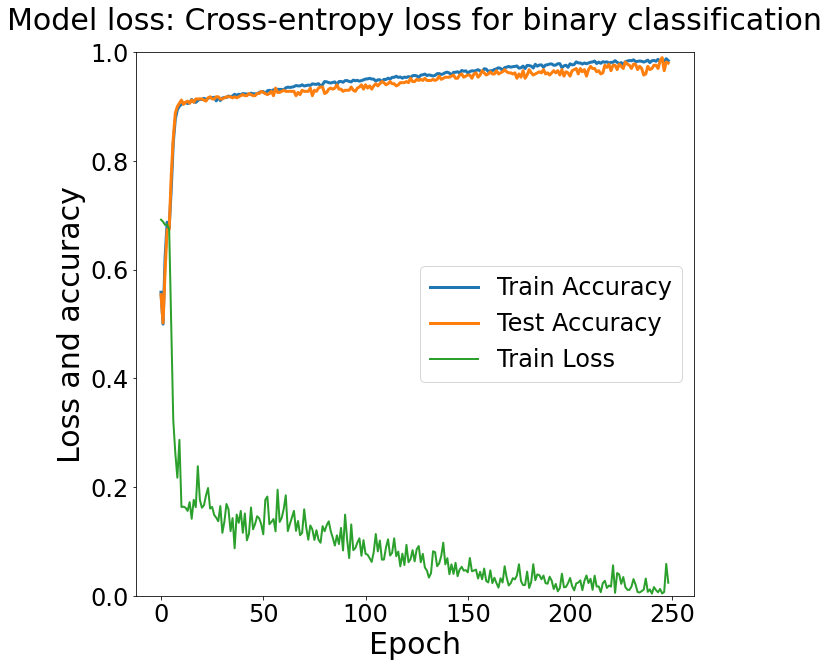

In [12]:
plt.figure(figsize=(10,10))
plt.plot(train_accuray, linewidth=3.0)
plt.plot(test_accuracy, linewidth=3.0)
plt.plot(train_loss, linewidth=2.0)
plt.title('Model loss: Cross-entropy loss for binary classification',fontsize=30,y=1.03)
plt.ylim(0,1)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.ylabel('Loss and accuracy',fontsize=30)
plt.xlabel('Epoch',fontsize=30)
plt.legend(['Train Accuracy', 'Test Accuracy', 'Train Loss'], loc='right',fontsize=24)
plt.savefig('Accuracy_plot')

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import numpy 
y_true = []
y_pred = []

def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        correct+= int((pred == data.y).sum())
        y_true.append(data.y.numpy())
        y_pred.append(pred.numpy())        
    return correct/len(loader.dataset)


test_acc = test(test_loader)
print(f'Test acc: {test_acc:.4f}')
# y_pred = y_pred[1].numpy()
# y_true = y_true[1].numpy()
y_pred = numpy.concatenate((y_pred[0],y_pred[1], y_pred[2], y_pred[3], y_pred[4], y_pred[5], y_pred[6],y_pred[7]))
y_true = numpy.concatenate((y_true[0],y_true[1], y_true[2], y_true[3], y_true[4], y_true[5], y_true[6],y_true[7]))
print(y_pred)
print(y_true)

In [ ]:
confusion_matrix(y_true, y_pred)

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

cf_matrix = confusion_matrix(y_true, y_pred)

# df_cm = pd.DataFrame(array, range(2), range(2))
# # plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
# # sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size


group_names = ['True Concave','False Convex','False Concave','True Convex']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sn.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

plt.show()

In [ ]:
print("Loading data....")
dataset = MyOwnDataset(root = "final_permu_data/")
dataset = dataset.shuffle()
print("Dataset length: ", len(dataset))
print()

data_loader = DataLoader(dataset[0:500], batch_size=64, shuffle=False)
print(f'Number of training batches created: {len(data_loader)}')
print()



In [ ]:
y_true = []
y_pred = []

def test(loader):
    model.eval()
    correct = 0
    for data in data_loader:
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        correct+= int((pred == data.y).sum())
        y_true.append(data.y.numpy())
        y_pred.append(pred.numpy())        
    return correct/len(loader.dataset)


test_acc = test(test_loader)
print(f'Test acc: {test_acc:.4f}')
# y_pred = y_pred[1].numpy()
# y_true = y_true[1].numpy()
y_pred = numpy.concatenate((y_pred[0],y_pred[1], y_pred[2], y_pred[3], y_pred[4], y_pred[5], y_pred[6],y_pred[7]))
y_true = numpy.concatenate((y_true[0],y_true[1], y_true[2], y_true[3], y_true[4], y_true[5], y_true[6],y_true[7]))
print(y_pred)
print(y_true)

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

cf_matrix = confusion_matrix(y_true, y_pred)

# df_cm = pd.DataFrame(array, range(2), range(2))
# # plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
# # sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size


group_names = ['True Concave','False Convex','False Concave','True Convex']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sn.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

plt.show()